In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arff

from scipy.stats import spearmanr
from itertools import combinations

In [44]:
def convert_df(path):
    dframe = pd.read_parquet(path)
    dframe.index = pd.to_datetime(dframe['datumEindeMeting'])
    dframe.drop(columns=['datumEindeMeting', 'datumBeginMeting'], inplace=True)
    dframe = dframe["hstWaarde"].astype(float)
    return dframe[:-1]

ammonium_df = convert_df("../../data/tank1/ammonium.parquet")
nitrate_df = convert_df("../../data/tank1/nitrate.parquet")
phosphate_df = convert_df("../../data/tank1/phosphate.parquet")
oxygen_df = convert_df("../../data/tank1/oxygen_a.parquet")
oxygen_df2 = convert_df("../../data/tank1/oxygen_b.parquet")
energy_df = convert_df("../../data/tank1/energy.parquet")
water_df = pd.read_csv("../../data/tank1/water.csv", delimiter=";")

# Preprocessing water data
water_df.index = pd.to_datetime(water_df['DateTime'], format='%d-%m-%Y %H:%M')
water_df['EDE_09902MTW_K100.MTW'] = water_df['EDE_09902MTW_K100.MTW'].str.replace(',', '.').replace('(null)', np.nan, regex=True).astype(float)
water_df['EDE_09902MTW_K100.MTW'] = water_df['EDE_09902MTW_K100.MTW'].interpolate()
water_df = water_df['EDE_09902MTW_K100.MTW']
water_df.index.name = None
water_df = water_df[water_df.index.isin(oxygen_df.index)]
water_df = water_df[~water_df.index.duplicated()]

# Synchronizing data
ammonium_df = ammonium_df[ammonium_df.index.isin(water_df.index)]
nitrate_df = nitrate_df[nitrate_df.index.isin(water_df.index)]
phosphate_df = phosphate_df[phosphate_df.index.isin(water_df.index)]
oxygen_df = oxygen_df[oxygen_df.index.isin(water_df.index)]
oxygen_df2 = oxygen_df2[oxygen_df2.index.isin(water_df.index)]
energy_df = energy_df[energy_df.index.isin(water_df.index)]

ammonium_df.name = "Ammonium"
nitrate_df.name = "Nitrate"
phosphate_df.name = "Phosphate"
oxygen_df.name = "Oxygen Sensor A"
oxygen_df2.name = "Oxygen Sensor B"
energy_df.name = "Energy"
water_df.name = "Water Flow"

dataframes = [ammonium_df, nitrate_df, phosphate_df, oxygen_df, oxygen_df2, energy_df]

merged_df = pd.concat([phosphate_df, ammonium_df, nitrate_df, energy_df, water_df, oxygen_df, oxygen_df2], axis=1)
merged_df.columns = ['Phosphate', 'Ammonium', 'Nitrate', 'Energy', 'WaterFlow', 'Oxygen_Sensor_A', 'Oxygen_Sensor_B']

In [28]:
'''
Spearman rank correlation
if p < 0.05 => significant correlation
'''

results = []
for df1, df2 in combinations(dataframes, 2):
    correlation, p_value = spearmanr(df1, df2)
    results.append({'DataFrame1': df1.name, 'DataFrame2': df2.name, 'Correlation': correlation, 'P-Value': p_value})

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

results_df

,DataFrame1,DataFrame2,Correlation,P-Value
0,Ammonium,Nitrate,0.255509,0.000000e+00
1,Ammonium,Phosphate,0.393990,0.000000e+00
2,Ammonium,Oxygen Sensor A,0.409609,0.000000e+00
3,Ammonium,Oxygen Sensor B,0.316948,0.000000e+00
4,Ammonium,Energy,-0.568094,0.000000e+00
5,Nitrate,Phosphate,-0.129561,0.000000e+00
6,Nitrate,Oxygen Sensor A,0.292268,0.000000e+00
7,Nitrate,Oxygen Sensor B,0.262069,0.000000e+00
8,Nitrate,Energy,-0.074864,0.000000e+00
9,Phosphate,Oxygen Sensor A,0.282068,0.000000e+00


### Spearman's Rank Correlation Insights

#### Correlation Types:
- **Positive Correlations**: Higher values in one variable are associated with higher values in another (e.g., Ammonium and Oxygen Sensor A: 0.409609). (suggests that when one variable increases, the other tends to increase as well)
- **Negative Correlations**: Higher values in one variable are associated with lower values in another (e.g., Ammonium and Energy: -0.568094). (suggests that when one variable increases, the other tends to decrease as well)

#### Correlation Strength:
- **Strong Correlation**: Values close to 1 or -1 indicate a stronger relationship (e.g., Oxygen Sensor A and Oxygen Sensor B: 0.708381).
- **Weak Correlation**: Small absolute values indicate a weaker relationship (e.g., Nitrate and Energy: -0.074864).

#### Statistical Significance:
- All correlations are statistically significant with p-values close to 0, indicating reliability in the observed correlations.

#### Specific Insights:
- The strongest positive correlation is between the two Oxygen Sensors, suggesting similar measurement conditions or related environmental aspects.
- Ammonium and Energy's negative correlation might reflect a biological or chemical process influencing energy yields.
- The weak negative correlation between Nitrate and Phosphate and the negligible correlation between Phosphate and Energy suggest limited direct relationships.

#### Considerations:
- Correlation does not imply causation; further analysis is required to understand these relationships.

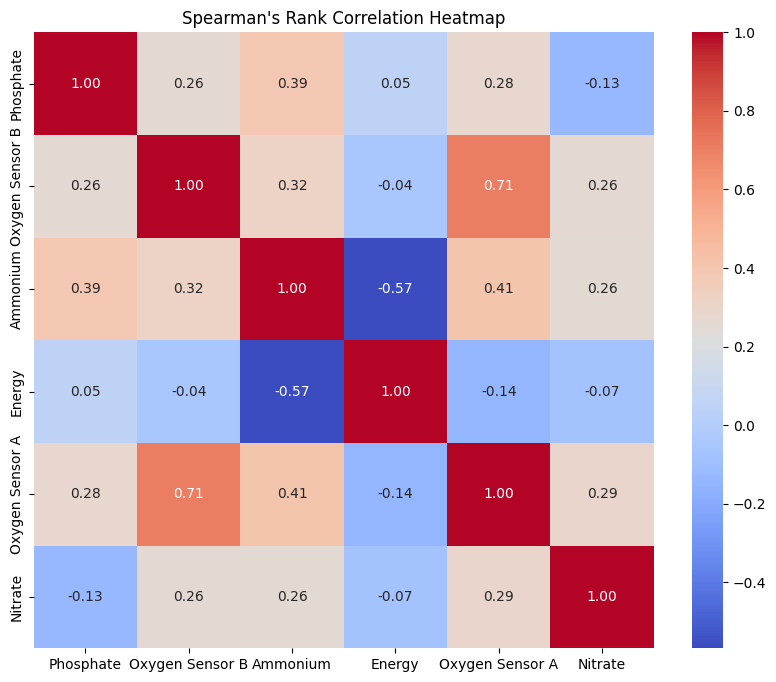

In [37]:
hmap_df = results_df[['DataFrame1','DataFrame2','Correlation']]

unique_dfs = set(results_df['DataFrame1']).union(set(results_df['DataFrame2']))
unique_dfs = list(unique_dfs)
correlation_matrix = pd.DataFrame(index=unique_dfs, columns=unique_dfs)

# Populate the matrix with correlation values
for index, row in results_df.iterrows():
    df1, df2, corr = row['DataFrame1'], row['DataFrame2'], row['Correlation']
    correlation_matrix.at[df1, df2] = corr
    correlation_matrix.at[df2, df1] = corr

# Fill diagonal and NaN values
np.fill_diagonal(correlation_matrix.values, 1)
correlation_matrix = correlation_matrix.fillna(0)

correlation_matrix = correlation_matrix.astype(float)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Spearman\'s Rank Correlation Heatmap')
plt.show()

[4.487 4.263 4.173 ... 2.264 2.273 2.281] [6.14  6.118 5.963 ... 6.904 6.985 6.992]
[4.487 4.263 4.173 ... 2.264 2.273 2.281] [0.185 0.126 0.108 ... 1.944 2.092 2.133]
[4.487 4.263 4.173 ... 2.264 2.273 2.281] [24014952. 24014955. 24014958. ... 25652337. 25652342. 25652346.]
[4.487 4.263 4.173 ... 2.264 2.273 2.281] [0.003 0.003 0.003 ... 1.689 1.693 1.702]
[4.487 4.263 4.173 ... 2.264 2.273 2.281] [0.029 0.028 0.028 ... 0.559 0.554 0.568]
[6.14  6.118 5.963 ... 6.904 6.985 6.992] [0.185 0.126 0.108 ... 1.944 2.092 2.133]
[6.14  6.118 5.963 ... 6.904 6.985 6.992] [24014952. 24014955. 24014958. ... 25652337. 25652342. 25652346.]
[6.14  6.118 5.963 ... 6.904 6.985 6.992] [0.003 0.003 0.003 ... 1.689 1.693 1.702]
[6.14  6.118 5.963 ... 6.904 6.985 6.992] [0.029 0.028 0.028 ... 0.559 0.554 0.568]
[0.185 0.126 0.108 ... 1.944 2.092 2.133] [24014952. 24014955. 24014958. ... 25652337. 25652342. 25652346.]
[0.185 0.126 0.108 ... 1.944 2.092 2.133] [0.003 0.003 0.003 ... 1.689 1.693 1.702]
[0.1

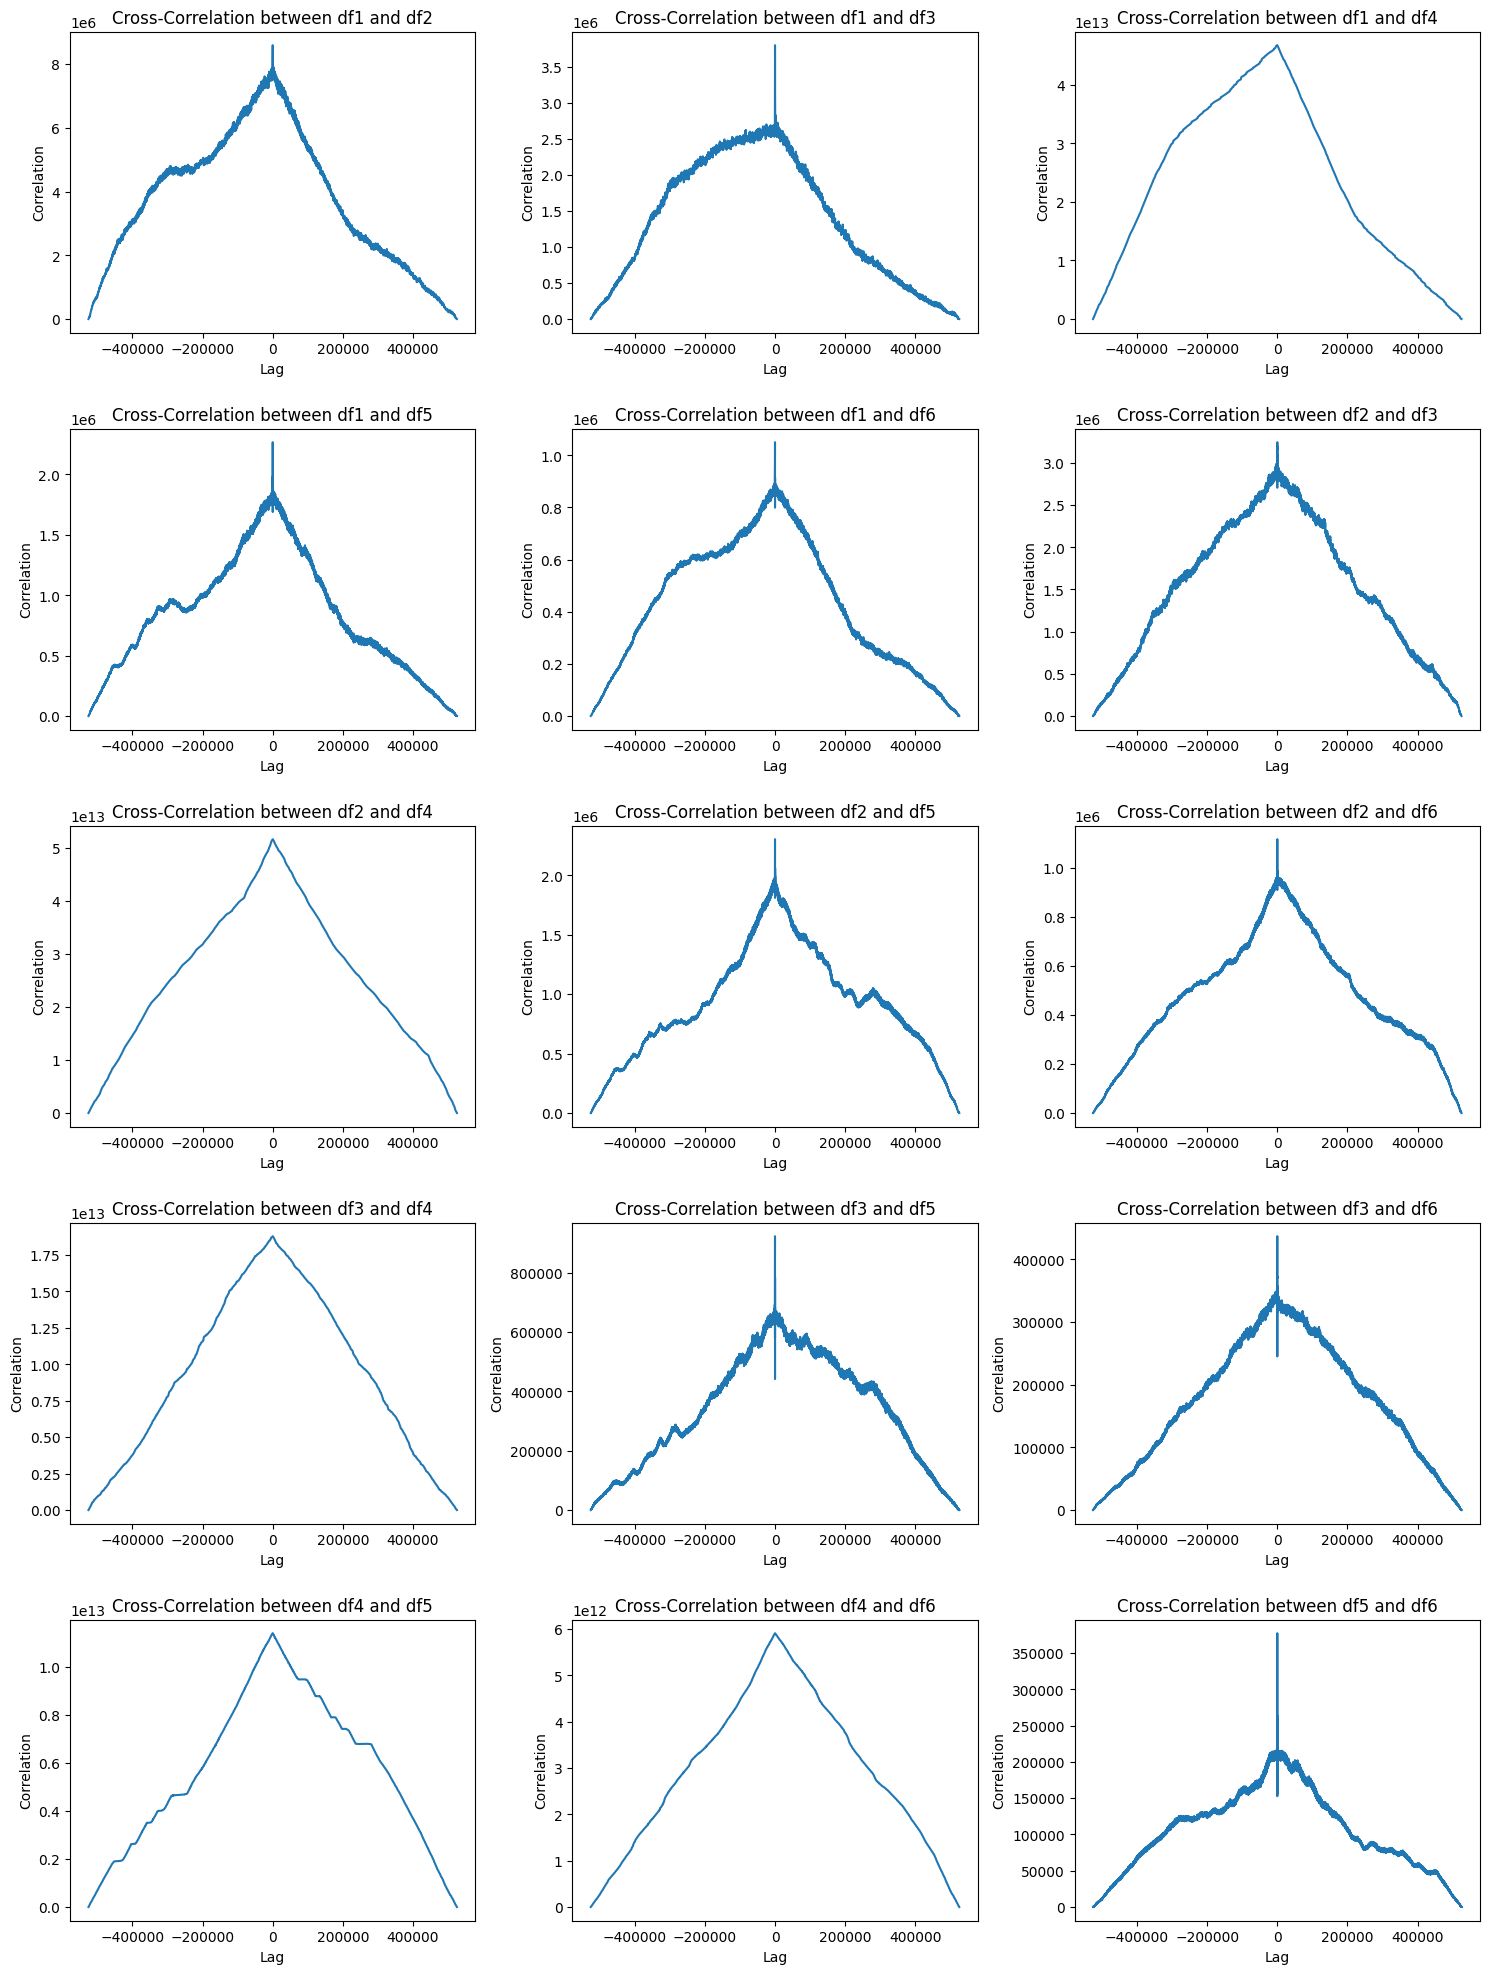

In [48]:
time_series_data = {
    'df1': np.array(ammonium_df),
    'df2': np.array(nitrate_df),
    'df3': np.array(phosphate_df),
    'df4': np.array(energy_df),
    'df5': np.array(oxygen_df),
    'df6': np.array(oxygen_df2),
}

# Function to compute cross-correlation
def compute_cross_correlation(series1, series2):
    print(series1, series2)
    lags = np.arange(-len(series1) + 1, len(series2))
    corr = np.correlate(series1, series2, mode='full')
    return lags, corr

# Iterate over each pair of dataframes and plot cross-correlation
plt.figure(figsize=(15, 20))
plot_number = 1
for (name1, series1), (name2, series2) in combinations(time_series_data.items(), 2):
    lags, corr = compute_cross_correlation(series1, series2)
    plt.subplot(5, 3, plot_number)
    plt.plot(lags, corr)
    plt.title(f'Cross-Correlation between {name1} and {name2}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plot_number += 1

plt.tight_layout()
plt.show()